# Generating adversarial examples on MNIST using C&W and DDN

In this notebook we will generate adversarial examples on MNIST using two methods:

* Carlini and Wagner (C&W) L2 attack (https://arxiv.org/abs/1608.04644)
* Decoupled Direction and Norm (DDN) (https://arxiv.org/abs/1811.09600)

We will attack a robust model trained with DDN - the noise required to attack an image is quite noticeable for this model.

Note: this example requires matplotlib (pip install matplotlib)

In [1]:
import argparse
import torch
import time
from torch.utils import data
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

from fast_adv.models.mnist import SmallCNN
from fast_adv.attacks import DDN, CarliniWagnerL2
from fast_adv.utils import requires_grad_, l2_norm
import matplotlib.pyplot as plt
import os
%matplotlib inline

torch.manual_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
data_path = 'data/mnist'  # Change this if you already downloaded MNIST elsewhere
model_url = 'https://www.dropbox.com/s/9onr3jfsuc3b4dh/mnist.pth?dl=1'
model_path = 'mnist.pth'

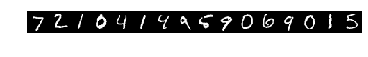

In [2]:
# Loading the data
dataset = datasets.MNIST(data_path, train=False,
                         transform=transforms.ToTensor(),
                         download=True)
loader = data.DataLoader(dataset, shuffle=False, batch_size=16)

x, y = next(iter(loader))
x = x.to(device)
y = y.to(device)

plt.imshow(make_grid(x, nrow=16).permute(1,2,0))
plt.axis('off');

In [3]:
print('Loading model')

if not os.path.exists(model_path):
    import urllib  
    print('Downloading model')
    urllib.request.urlretrieve(model_url, model_path)


model = SmallCNN()
model.load_state_dict(torch.load(model_path))
model.eval().to(device)
requires_grad_(model, False)

Loading model


Running DDN 100 attack
Completed in 0.40s


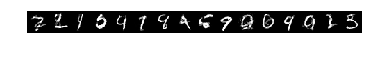

In [4]:
print('Running DDN 100 attack')
attacker = DDN(steps=100, device=device)
start = time.time()
ddn_atk = attacker.attack(model, x, labels=y, targeted=False)
ddn_time = time.time() - start
print('Completed in {:.2f}s'.format(ddn_time))

plt.imshow(make_grid(ddn_atk, nrow=16).permute(1,2,0))
plt.axis('off');

Running C&W 4 x 25 attack (limited to 100 iterations)
Completed in 0.59s


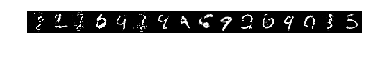

In [5]:
print('Running C&W 4 x 25 attack (limited to 100 iterations)')
cwattacker100 = CarliniWagnerL2(device=device,
                             image_constraints=(0, 1),
                             num_classes=10,
                             search_steps=4,
                             max_iterations=25,
                             learning_rate=0.5, 
                             initial_const=1.0)

start = time.time()
cw100_atk = cwattacker100.attack(model, x, labels=y, targeted=False)
cw100_time = time.time() - start
print('Completed in {:.2f}s'.format(cw100_time))

plt.imshow(make_grid(cw100_atk, nrow=16).permute(1,2,0))
plt.axis('off');

Running C&W 9 x 10000 attack
Completed in 177.87s


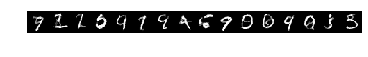

In [6]:
print('Running C&W 9 x 10000 attack')
cwattacker = CarliniWagnerL2(device=device,
                             image_constraints=(0, 1),
                             num_classes=10)

start = time.time()
cw_atk = cwattacker.attack(model, x, labels=y, targeted=False)
cw_time = time.time() - start
print('Completed in {:.2f}s'.format(cw_time))

plt.imshow(make_grid(cw_atk, nrow=16).permute(1,2,0))
plt.axis('off');

C&W 4 x 25 done in 0.6s: Success: 100.00%, Mean L2: 4.4013.
C&W 9 x 10000 done in 177.9s: Success: 100.00%, Mean L2: 2.7124.
DDN 100 done in 0.4s: Success: 100.00%, Mean L2: 2.9836.

Figure: top row: original images; 2nd: C&W 4x25 atk; 3rd: C&W 9x10000 atk; 4th: DDN 100 atk


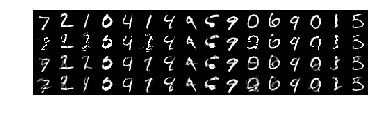

In [7]:
all_imgs = torch.cat((x, cw100_atk, cw_atk, ddn_atk))
img_grid = make_grid(all_imgs, nrow=16, pad_value=0)
plt.imshow(img_grid.permute(1,2,0))
plt.axis('off')

# Print metrics
pred_orig = model(x).argmax(dim=1).cpu()
pred_cw = model(cw_atk).argmax(dim=1).cpu()
pred_cw100 = model(cw100_atk).argmax(dim=1).cpu()
pred_ddn = model(ddn_atk).argmax(dim=1).cpu()
print('C&W 4 x 25 done in {:.1f}s: Success: {:.2f}%, Mean L2: {:.4f}.'.format(
    cw100_time,
    (pred_cw100 != pred_orig).float().mean().item() * 100,
    l2_norm(cw100_atk - x).mean().item()
))
print('C&W 9 x 10000 done in {:.1f}s: Success: {:.2f}%, Mean L2: {:.4f}.'.format(
    cw_time,
    (pred_cw != pred_orig).float().mean().item() * 100,
    l2_norm(cw_atk - x).mean().item()
))
print('DDN 100 done in {:.1f}s: Success: {:.2f}%, Mean L2: {:.4f}.'.format(
    ddn_time,
    (pred_ddn != pred_orig).float().mean().item() * 100,
    l2_norm(ddn_atk - x).mean().item()
))
print()
print('Figure: top row: original images; 2nd: C&W 4x25 atk; 3rd: C&W 9x10000 atk; 4th: DDN 100 atk')